In [3]:
import cv2
import re
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from CellClicker.manageXML import check_xml, append_cell_regions_xml, find_labels_and_extract_rois, get_all_label_names, get_series_count_for_label
from CellClicker.clicker_utils import get_previous_image_name, append_yolov5_label
# Assuming your images are stored in a list of numpy arrays named 'image_sets'
# image_sets = [np.array of shape (8, x, y), ..., np.array of shape (8, x, y)] for 10 sets

selected_indices = []  # To store the selected indices
image_sets =[]




# Load image sets from the folder
# folder_path = filedialog.askdirectory(title="Select Folder Containing TIF Files")
# file_paths = sorted(glob.glob(os.path.join(folder_path, '*.tif')))
# image_sets = [np.array([tifffile.imread(file) for file in file_paths[i:i + 8]]) for i in range(0, len(file_paths), 8)]

selected_indices = []  # To store the selected indices



# Main Tkinter window
# root = tk.Tk()
# root.withdraw()  # Hide main window

# # Start displaying the sets
# display_set(image_sets[0], 0)

# root.mainloop()

roi_list = []
# def get_previous_image_name(image_name):
#     """Decrease the timepoint of the image by one and return the new image name."""
#     # Extract the timepoint using regular expression
#     match = re.search(r't(\d{3})\.jpg$', image_name)
#     if match:
#         timepoint = int(match.group(1))
#         # If timepoint is already 0, keep it as is (or handle accordingly)
#         timepoint = max(0, timepoint - 1)
#         # Replace the old timepoint with the new one in the image name
#         new_image_name = re.sub(r't\d{3}\.jpg$', f't{timepoint:03}.jpg', image_name)
#         return new_image_name
#     else:
#         return None  # Return None if the format doesn't match
def normalize_image(image):

    # Normalize the image to the range [0, 1]
    # Normalize the image to the range [0, 255]
    image = (image - image.min()) / (image.max() - image.min()) * 255

    # Convert the image to uint8 data type
    image = image.astype(np.uint8)

    return image

def click_event(event, x, y, flags, param):
    """Callback function to handle mouse click events."""
    if event == cv2.EVENT_LBUTTONDOWN:
        print('clicked')
        # Adjust the clicked coordinates to the original image's coordinates
        class_id = param['class_id']
        
        x_global = x + param['x']
        y_global = y + param['y']
        print(f"Clicked at coordinates in the local image: x={x}, y={y}")
        print(f"wh : x={param['width']}, y={param['height']}")
        print(f"Clicked at coordinates in the original image: x={x_global}, y={y_global}")
        xml_path = param['xml_path']
        
        # Calculate new ROI centered at the clicked position
        x_start = x_global - param['width']//2
        y_start = y_global - param['height']//2
        
        # Ensure the new ROI doesn't go beyond the image boundaries
        x_start = max(0, x_start)
        y_start = max(0, y_start)
        
        x_end = x_start + param['width']
        y_end = y_start + param['height']
        
        label_file_path = param['image_name'].replace('images', 'labels').replace('.png', '.txt')
        roi_center_x = (x_start + x_end) / 2
        roi_center_y = (y_start + y_end) / 2
#         print(param)
#         print(label_file_path)
#         append_yolov5_label(label_file_path, roi_center_x, roi_center_y, param['width'], param['height'], param['img'].shape[1], param['img'].shape[0], class_id)
        
            
#         print(xml_path, param['first_label'], class_id, roi_center_x, roi_center_y, param['width'], param['height'], param['img'].shape[1], param['img'].shape[0], param['series_count'])
        append_cell_regions_xml(xml_path, param['first_label'], class_id, roi_center_x, roi_center_y, param['width'], param['height'], param['img'].shape[1], param['img'].shape[0], param['series_count'])
        
        class_id += 1
        param['class_id'] = class_id
        prev_image_name = get_previous_image_name(param['image_name'])
#         cap at 8 images or no file
        if class_id == 9 or not prev_image_name:
#               cv2.waitKey(0)
              cv2.destroyAllWindows()
              
        else :
            # Update the image in the param
            param['img'] = cv2.imread(prev_image_name)
            param['image_name'] = prev_image_name
            print("Update image name")
            print(param['image_name'])
        
            # Extract and display the new ROI
            new_roi = param['img'][y_start:y_end, x_start:x_end]
            new_roi = normalize_image(new_roi)
            roi_list.append(new_roi)
            cv2.imshow('Cell clicker', new_roi)
            param['x'] = x_start
            param['y'] = y_start
            cv2.setMouseCallback('Cell clicker', click_event, param)  # set the callback for the new window as well


def display_roi(image_path, label_dict, xml_path):
              
    """
    Display the subsection of an image and calculates a new ROI centered on clicked position.

    Parameters:
    - image_path: path to the image file.
    - label_dict: a dictionary containing 'x', 'y', 'width', 'height', and 'label'.
    """
    
              
    class_id = 0
    # Read the image using OpenCV
    img = cv2.imread(image_path)
    y_shape, x_shape = img.shape[0], img.shape[1]

    # Extract the ROI from the image
    x, y, w, h = int(label_dict['x']), int(label_dict['y']), int(label_dict['width']), int(label_dict['height'])
    print(x, y, w, h)
    # increase the view
    expand = 10
    x = max(0, x-expand)
    y = max(0, y-expand)
    w = min(x_shape, x+w+int(expand*2))-x
    h = min(y_shape, y+h+int(expand*2))-y
    print(x, y, w, h)


    roi = img[y:y+h, x:x+w]
    roi = normalize_image(roi)
    roi_list.append(roi)
    print("roi append")
    # Append the new YOLOv5 label
    label_file_path = image_path.replace('images', 'labels').replace('.png', '.txt')
    roi_center_x = (x + x+w) / 2
    roi_center_y = (y + y+h) / 2
#     append_yolov5_label(label_file_path, roi_center_x, roi_center_y, w, h, img.shape[1], img.shape[0], class_id)
    

    # Display the ROI
    cv2.imshow('Cell clicker', roi)
    print("open clicker")
    # Set the mouse callback to calculate new ROI on click
    print(label_file_path)
    series_count = get_series_count_for_label(xml_path, label_file_path)
    print(series_count)
    series_count+=1
    param = {'x': x, 'y': y, 'width': w, 'height': h, 'img': img, 'image_name' : image_path , 'class_id': class_id, 'series_count' : series_count, 'first_label': label_file_path, 'xml_path': xml_path}
    print("before callback")
    cv2.setMouseCallback('Cell clicker', click_event, param)
    print("aftercallback")
#     # Wait for a key press and then close the window
    cv2.waitKey(0)
#     cv2.destroyAllWindows()
              
    plt.figure(figsize=(15, 10))
    total_rois = len(roi_list)
    for idx, roi in enumerate(reversed(roi_list)):
        plt.subplot(1, total_rois, idx + 1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct matplotlib display
        plt.title(f"Delta: {idx - (total_rois - 1)}")
        plt.axis('off')  # Hide axis
    plt.tight_layout()
    plt.savefig((image_path.split('/images/')[1]).split('.png')[0]+"_rois.png", bbox_inches='tight', dpi=300)
    plt.show()



In [1]:
import cv2
import numpy as np
from CellClicker.manageXML import check_xml, append_cell_regions_xml, get_series_count_for_label
from CellClicker.clicker_utils import get_previous_image_name

def normalize_image(image):
    """
    Normalizes an image to a range of [0, 255] and converts it to uint8 data type.
    """
    image = (image - image.min()) / (image.max() - image.min()) * 255
    return image.astype(np.uint8)

def click_event(event, x, y, flags, param):
    """
    Handles mouse click events to calculate a new ROI centered on the clicked position.
    Adjusts for the clicked coordinates relative to the original image.
    """
    if event == cv2.EVENT_LBUTTONDOWN:
        # Calculate global coordinates
        x_global = x + param['x']
        y_global = y + param['y']
        print(f"Clicked at local: x={x}, y={y}, global: x={x_global}, y={y_global}")

        # Adjust ROI to ensure it does not go beyond image boundaries
        x_start = max(0, x_global - param['width'] // 2)
        y_start = max(0, y_global - param['height'] // 2)
        x_end = x_start + param['width']
        y_end = y_start + param['height']

        # Append ROI to XML
        append_cell_regions_xml(param['xml_path'], param['first_label'], param['class_id'],
                                (x_start + x_end) / 2, (y_start + y_end) / 2,
                                param['width'], param['height'], param['img'].shape[1], param['img'].shape[0], param['series_count'])

        # Prepare for next image or close if limit reached
        param['class_id'] += 1
        
        prev_image_name = get_previous_image_name(param['image_name'])
        if prev_image_name:
            update_image(param, prev_image_name, x_start, y_start)
        else:
            end_session()

def end_session():
    """
    Function to close all OpenCV windows and quit the Tkinter main loop.
    """
    cv2.destroyAllWindows()

def update_image(param, image_name, x_start, y_start):
    """
    Updates the image for display after clicking, adjusting the ROI and re-binding the click event.
    """
    param['image_name'] = image_name
    param['img'] = cv2.imread(image_name)
    new_roi = normalize_image(param['img'][y_start:y_start+param['height'], x_start:x_start+param['width']])
    cv2.imshow('Cell clicker', new_roi)
    param['x'] = x_start
    param['y'] = y_start
    cv2.setMouseCallback('Cell clicker', click_event, param)

def display_roi(image_path, label_dict, xml_path):
    """
    Displays an ROI centered at a specified location from an image, setting up mouse click callback.
    """
    img = cv2.imread(image_path)
    y_shape, x_shape = img.shape[:2]
    
    # Calculate expanded ROI dimensions
    expand = 10
    x, y = max(0, label_dict['x'] - expand), max(0, label_dict['y'] - expand)
    w = min(x_shape, label_dict['x'] + label_dict['width'] + 2*expand) - x
    h = min(y_shape, label_dict['y'] + label_dict['height'] + 2*expand) - y
    roi = normalize_image(img[y:y+h, x:x+w])

    # Display and setup callback
    cv2.imshow('Cell clicker', roi)

    label_file_path = image_path.replace('images', 'labels').replace('.png', '.txt')
    series_count = get_series_count_for_label(xml_path, label_file_path)
    param = {'x': x, 'y': y, 'width': w, 'height': h, 'img': img, 'image_name': image_path,
             'class_id': 0, 'series_count': series_count + 1, 'first_label': label_file_path, 'xml_path': xml_path}
    cv2.setMouseCallback('Cell clicker', click_event, param)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [1]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import Button, Toplevel
from CellClicker.manageXML import get_series_count_for_label, append_cell_regions_xml, check_xml
from CellClicker.clicker_utils import get_previous_image_name

class ImageProcessor:
    def __init__(self, master):
        self.master = master
        self.master.title("Control Panel")
        
        
        # Button to manually end the session
        self.stop_button = Button(master, text="Stop and Close", command=self.end_session)
        self.stop_button.pack()
        
        # Window for displaying images
        self.image_window = Toplevel(self.master)
        self.image_window.title("Cell Clicker")
        
    def normalize_image(self, image):
        """ Normalizes an image to a range of [0, 255] and converts it to uint8 data type. """
        image = (image - image.min()) / (image.max() - image.min()) * 255
        return image.astype(np.uint8)
    
    def click_event(self, event, x, y, flags, param):
        """ Handles mouse click events to calculate a new ROI centered on the clicked position. """
        if event == cv2.EVENT_LBUTTONDOWN:
            x_global = x + param['x']
            y_global = y + param['y']
            
            x_start = max(0, x_global - param['width'] // 2)
            y_start = max(0, y_global - param['height'] // 2)
            x_end = x_start + param['width']
            y_end = y_start + param['height']

            
            append_cell_regions_xml(param['xml_path'], param['first_label'], param['class_id'],
                                    (x_start + x_end) / 2, (y_start + y_end) / 2,
                                    param['width'], param['height'], param['img'].shape[1], param['img'].shape[0], param['series_count'])

            param['class_id'] += 1
            
            prev_image_name = get_previous_image_name(param['image_name'])
            if prev_image_name:
                self.update_image(param, prev_image_name, x_start, y_start)
            else:
                self.end_session()
    
    def end_session(self):
        """ Closes all OpenCV windows and quits the Tkinter main loop. """
        cv2.destroyAllWindows()
        self.master.quit()
    
    def update_image(self, param, image_name, x_start, y_start):
        """ Updates the image for display after clicking, adjusting the ROI and re-binding the click event. """
        param['image_name'] = image_name
        param['img'] = cv2.imread(image_name)
        new_roi = self.normalize_image(param['img'][y_start:y_start+param['height'], x_start:x_start+param['width']])
        cv2.imshow('Cell clicker', new_roi)
        param['x'] = x_start
        param['y'] = y_start
        cv2.setMouseCallback('Cell clicker', self.click_event, param)
    
    def display_roi(self, image_path, label_dict, xml_path):
        """ Displays an ROI centered at a specified location from an image, setting up mouse click callback. """
        img = cv2.imread(image_path)
        y_shape, x_shape = img.shape[:2]
        expand = 10
        x, y = max(0, label_dict['x'] - expand), max(0, label_dict['y'] - expand)
        w = min(x_shape, label_dict['x'] + label_dict['width'] + 2*expand) - x
        h = min(y_shape, label_dict['y'] + label_dict['height'] + 2*expand) - y
        roi = self.normalize_image(img[y:y+h, x:x+w])

        cv2.imshow('Cell clicker', roi)
        
        label_file_path = image_path.replace('images', 'labels').replace('.png', '.txt')
        series_count = get_series_count_for_label(xml_path, label_file_path)
        param = {'x': x, 'y': y, 'width': w, 'height': h, 'img': img, 'image_name': image_path,
                 'class_id': 0, 'series_count': series_count + 1, 'first_label': label_file_path, 'xml_path': xml_path}
        cv2.setMouseCallback('Cell clicker', self.click_event, param)




REsizing

In [2]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import os

class ImageViewer:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Viewer")
        

        # Set up the frame for navigation buttons
        frame = tk.Frame(self.root)
        frame.pack(side=tk.BOTTOM, pady=20)

        # Buttons
        self.btn_back = tk.Button(frame, text="<<", command=self.prev_image, state=tk.DISABLED)
        self.btn_back.pack(side=tk.LEFT)
        self.btn_forward = tk.Button(frame, text=">>", command=self.next_image)
        self.btn_forward.pack(side=tk.LEFT)
        self.btn_inspect = tk.Button(frame, text="Inspect", command=self.inspect_bbox)
        self.btn_inspect.pack(side=tk.RIGHT)

        # Label for image name
        self.label = tk.Label(self.root, text='', pady=10)
        self.label.pack(side=tk.BOTTOM)

        # Canvas for image display
        self.canvas = tk.Canvas(self.root, cursor="cross")
        self.canvas.pack(fill=tk.BOTH, expand=True)

        # Binding mouse events
        self.canvas.bind("<ButtonPress-1>", self.start_bbox)
        self.canvas.bind("<B1-Motion>", self.expand_bbox)
        self.canvas.bind("<ButtonRelease-1>", self.finish_bbox)

        # Bind the configure event for resizing images
        self.original_image = None
        self.canvas.bind("<Configure>", self.handle_resize)

        self.start_x = None
        self.start_y = None
        self.rect = None
        self.bbox_details = None

        # Load images
        self.images = []
        self.current_image = 0
        self.load_images()

        # Initial image setup
        self.update_image()

    def load_images(self):
        # Ask the user for the directory
        directory = filedialog.askdirectory(title="Select Directory with Images")
        if not directory:
            return
        
        # List all image files in the directory
        supported_formats = (".png", ".jpg", ".jpeg", ".bmp", ".gif")
        directory = os.path.join(directory, "images")
        self.xml_path = os.path.join(directory, "cell_reigons.xml")
        current_df = check_xml(self.xml_path)
        print(current_df)
        self.images = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(supported_formats)]

        if not self.images:
            self.label.config(text="No images found!")
            return
        
        self.images.sort()


    def update_image(self):
        if not self.images:
            return

        img_path = self.images[self.current_image]
        self.original_image = Image.open(img_path)
        self.display_image()

    def handle_resize(self, event):
        # Resize based on the current canvas size, using the original image
        if self.original_image:
            self.resize_image(event.width, event.height)

    def resize_image(self, width, height):
        # Avoid resizing to zero to prevent PIL errors
        if width > 1 and height > 1:
            resized_image = self.original_image.resize((width, height), Image.Resampling.LANCZOS)
            self.photo_img = ImageTk.PhotoImage(resized_image)
            self.canvas.create_image(0, 0, image=self.photo_img, anchor=tk.NW)

    def display_image(self):
        if self.original_image:
            self.photo_img = ImageTk.PhotoImage(self.original_image)
            self.canvas.config(width=self.photo_img.width(), height=self.photo_img.height())
            self.canvas.create_image(0, 0, image=self.photo_img, anchor=tk.NW)
            self.label.config(text=os.path.basename(self.images[self.current_image]))
            self.canvas.delete(self.rect)
            self.rect = None
            # Update button states
            self.btn_back.config(state=tk.NORMAL if self.current_image > 0 else tk.DISABLED)
            self.btn_forward.config(state=tk.NORMAL if self.current_image < len(self.images) - 1 else tk.DISABLED)
            self.resize_image(self.canvas.winfo_width(), self.canvas.winfo_height())


    def start_bbox(self, event):
        # Remove previous bounding box if any
        if self.rect:
            self.canvas.delete(self.rect)
        # Save mouse drag start position
        self.start_x = event.x
        self.start_y = event.y
        self.rect = self.canvas.create_rectangle(self.start_x, self.start_y, self.start_x, self.start_y, outline='red')

    def expand_bbox(self, event):
        # Modify the current rectangle's corner to new mouse position
        self.canvas.coords(self.rect, self.start_x, self.start_y, event.x, event.y)

    def finish_bbox(self, event):
        # Finalize the rectangle
        self.canvas.coords(self.rect, self.start_x, self.start_y, event.x, event.y)
        x0, y0, x1, y1 = self.canvas.coords(self.rect)
        self.bbox_details = {'x': x0, 'y': y0, 'width': x1 - x0, 'height': y1 - y0}

    def inspect_bbox(self):
        if self.bbox_details and self.original_image:
            # Calculate scale factors
            scale_x = self.original_image.width / self.canvas.winfo_width()
            scale_y = self.original_image.height / self.canvas.winfo_height()

            # Adjust coordinates
            original_x = int(self.bbox_details['x'] * scale_x)
            original_y = int(self.bbox_details['y'] * scale_y)
            original_width = int(self.bbox_details['width'] * scale_x)
            original_height = int(self.bbox_details['height'] * scale_y)

            self.start_clicker({
                'x': original_x,
                'y': original_y,
                'width': original_width,
                'height': original_height
            })




    def start_clicker(self, bbox):
        print("Bounding Box Details:")
        print(f"Start Coordinates: ({bbox['x']}, {bbox['y']})")
        print(f"Width: {bbox['width']} pixels")
        print(f"Height: {bbox['height']} pixels")
        bbox['label'] = 'u-0'
        img_path = self.images[self.current_image]
        self.processor = ImageProcessor(self.root)
        self.processor.display_roi(img_path, bbox, self.xml_path)

    def next_image(self):
        if self.current_image < len(self.images) - 1:
            self.current_image += 1
            self.update_image()

    def prev_image(self):
        if self.current_image > 0:
            self.current_image -= 1
            self.update_image()

if __name__ == "__main__":
    root = tk.Tk()
    app = ImageViewer(root)
    root.mainloop()


Empty DataFrame
Columns: []
Index: []
Bounding Box Details:
Start Coordinates: (1123, 96)
Width: 45 pixels
Height: 102 pixels
series not found!
before label
label append
end
foundseries!
before label
label append
end
foundseries!
before label
label append
end
foundseries!
before label
label append
end
foundseries!
before label
label append
end
foundseries!
before label
label append
end


In [ ]:
from CellClicker.image_selector import load_selector, load_ui
load_ui("cell_regions.xml")

Selected XML: select_xmls/random.xml
AllLabels/labels/20220727_C3_P01_S1_t022.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
foundname
foundseries
AllLabels/labels/20220727_C3_P01_S1_t027.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
foundname
foundseries
foundseries
AllLabels/labels/20220727_C3_P01_S1_t028.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
foundname
foundseries
foundseries
AllLabels/labels/20220727_C3_P01_S1_t029.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
foundname
foundseries
AllLabels/labels/20220727_C3_P01_S1_t031.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/2022

foundseries
AllLabels/labels/20220727_C3_P01_S1_t062.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
foundname
foundseries
AllLabels/labels/20220727_C3_P01_S1_t063.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022

foundseries
foundseries
AllLabels/labels/20220727_C3_P01_S2_t029.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/2

AllLabels/labels/20220727_C3_P01_S2_t047.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P01_S2_t060.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P01_S2_t075.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P02_S1_t031.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P02_S1_t041.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P02_S1_t050.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P02_S1_t076.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P02_S2_t026.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P02_S2_t041.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P02_S2_t050.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

AllLabels/labels/20220727_C3_P02_S2_t075.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

foundseries
AllLabels/labels/20220727_C3_P03_S1_t022.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P

AllLabels/labels/20220727_C3_P03_S1_t030.txt
searching...
AllLabels/labels/20220727_C3_P01_S1_t022.txt
AllLabels/labels/20220727_C3_P01_S1_t027.txt
AllLabels/labels/20220727_C3_P01_S1_t028.txt
AllLabels/labels/20220727_C3_P01_S1_t029.txt
AllLabels/labels/20220727_C3_P01_S1_t031.txt
AllLabels/labels/20220727_C3_P01_S1_t037.txt
AllLabels/labels/20220727_C3_P01_S1_t041.txt
AllLabels/labels/20220727_C3_P01_S1_t044.txt
AllLabels/labels/20220727_C3_P01_S1_t052.txt
AllLabels/labels/20220727_C3_P01_S1_t048.txt
AllLabels/labels/20220727_C3_P01_S1_t054.txt
AllLabels/labels/20220727_C3_P01_S1_t055.txt
AllLabels/labels/20220727_C3_P01_S1_t056.txt
AllLabels/labels/20220727_C3_P01_S1_t057.txt
AllLabels/labels/20220727_C3_P01_S1_t058.txt
AllLabels/labels/20220727_C3_P01_S1_t059.txt
AllLabels/labels/20220727_C3_P01_S1_t061.txt
AllLabels/labels/20220727_C3_P01_S1_t062.txt
AllLabels/labels/20220727_C3_P01_S1_t063.txt
AllLabels/labels/20220727_C3_P01_S1_t068.txt
AllLabels/labels/20220727_C3_P01_S1_t071.t

In [4]:
from CellClicker.image_selector import xml_to_labels
xml_to_labels("select_xmls/batch1.xml","cell_regions.xml")

AllLabels/labels/20220329_C2_P01t015.txt
AllLabels/labels/20220329_C2_P02t014.txt
AllLabels/labels/20220329_C2_P03t011.txt
AllLabels/labels/20220329_C2_P03t012.txt
AllLabels/labels/20220329_C2_P03t010.txt
AllLabels/labels/20220329_C2_P03t008.txt
AllLabels/labels/20220329_C2_P04t011.txt
AllLabels/labels/20220329_C2_P04t014.txt
AllLabels/labels/20220329_C2_P05t014.txt
AllLabels/labels/20220329_C2_P05t011.txt
AllLabels/labels/20220329_C2_P04t009.txt
AllLabels/labels/20220329_C2_P04t013.txt
AllLabels/labels/20220329_C2_P05t007.txt
AllLabels/labels/20220329_C2_P06t010.txt
AllLabels/labels/20220329_C2_P06t009.txt
AllLabels/labels/20220329_C2_P06t011.txt
AllLabels/labels/20220329_C2_P06t012.txt
AllLabels/labels/20220329_C2_P06t012.txt
AllLabels/labels/20220329_C2_P06t013.txt
AllLabels/labels/20220329_C2_P06t016.txt
AllLabels/labels/20220329_C2_P06t016.txt
AllLabels/labels/20220329_C2_P07t007.txt
AllLabels/labels/20220329_C2_P07t008.txt
AllLabels/labels/20220329_C2_P07t013.txt
AllLabels/labels

Processing Group: ImageName=AllLabels/labels/20220329_C2_P01t007.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P01t007.txt, SeriesID=2
Processing Group: ImageName=AllLabels/labels/20220329_C2_P01t008.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P01t015.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P01t016.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P01t016.txt, SeriesID=2
Processing Group: ImageName=AllLabels/labels/20220329_C2_P02t013.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P02t014.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P02t015.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P03t008.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P03t010.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P03t011.txt, SeriesID=1
Processing Group: ImageName=

Processing Group: ImageName=AllLabels/labels/20220329_C3_P08t061.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t008.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t009.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t017.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t020.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t039.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t048.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t048.txt, SeriesID=2
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t057.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t059.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t060.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C3_P09t061.txt, SeriesID=1
Processing Group: ImageName=

In [1]:
from CellClicker.image_selector import debug_xml_to_labels2
mod_df = debug_xml_to_labels2("select_xmls/sara.xml","cell_regions.xml")

AllLabels/labels/20220329_C2_P01t015.txt
AllLabels/labels/20220329_C2_P02t014.txt
AllLabels/labels/20220329_C2_P03t011.txt
AllLabels/labels/20220329_C2_P03t012.txt
AllLabels/labels/20220329_C2_P03t010.txt
AllLabels/labels/20220329_C2_P03t008.txt
AllLabels/labels/20220329_C2_P04t011.txt
AllLabels/labels/20220329_C2_P04t014.txt
AllLabels/labels/20220329_C2_P05t014.txt
AllLabels/labels/20220329_C2_P05t011.txt
AllLabels/labels/20220329_C2_P04t009.txt
AllLabels/labels/20220329_C2_P04t013.txt
AllLabels/labels/20220329_C2_P05t007.txt
AllLabels/labels/20220329_C2_P06t010.txt
AllLabels/labels/20220329_C2_P06t009.txt
AllLabels/labels/20220329_C2_P06t011.txt
AllLabels/labels/20220329_C2_P06t012.txt
AllLabels/labels/20220329_C2_P06t012.txt
AllLabels/labels/20220329_C2_P06t013.txt
AllLabels/labels/20220329_C2_P06t016.txt
AllLabels/labels/20220329_C2_P06t016.txt
AllLabels/labels/20220329_C2_P07t007.txt
AllLabels/labels/20220329_C2_P07t008.txt
AllLabels/labels/20220329_C2_P07t013.txt
AllLabels/labels

In [4]:
grouped = mod_df.groupby(['PathName', 'SeriesID'])
#     print(grouped)
for (label_path, series_id), group in grouped:
    print(f"Processing Group: ImageName={label_path}, SeriesID={series_id}")
    

Processing Group: ImageName=AllLabels/labels/20220329_C2_P01t015.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P02t014.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P03t008.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P03t010.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P03t011.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P03t012.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P04t009.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P04t011.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P04t014.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P05t007.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P05t011.txt, SeriesID=1
Processing Group: ImageName=AllLabels/labels/20220329_C2_P05t014.txt, SeriesID=1
Processing Group: ImageName=

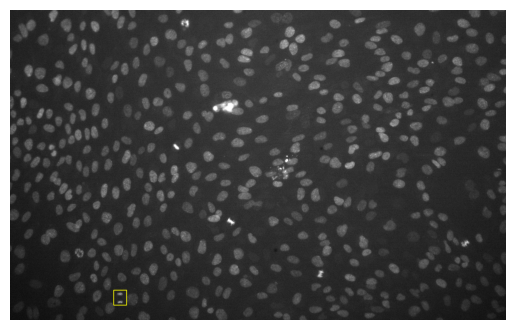

In [13]:
from skimage import io
import matplotlib.pyplot as plt
import cv2
example_path = "AllLabels/images/20220727_C3_P03_S1_t030.png"
img_gray = cv2.imread(example_path, cv2.IMREAD_GRAYSCALE)
height, width = img_gray.shape
# Convert the grayscale image to BGR (three channels)
img_color = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
box_width, box_height = int(0.026041666666666668*width), int(height*0.04833333333333333)

# Coordinates of the bounding box (example)
# Suppose we have a bounding box with top-left corner at (x1, y1) and bottom-right corner at (x2, y2)
x1, y1, x2, y2 = int(0.221875*width-box_width/2), int(0.92833*height-box_height/2), int(0.221875*width+box_width/2), int(0.92833*height+box_height/2)  # replace with your coordinates

# Draw a yellow rectangle on the color image
# Yellow in BGR format
cv2.rectangle(img_color, (x1, y1), (x2, y2), (0, 255, 255), 2)

# Convert the image from BGR to RGB for displaying in matplotlib
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(img_rgb)
plt.axis('off')
plt.show()
# 

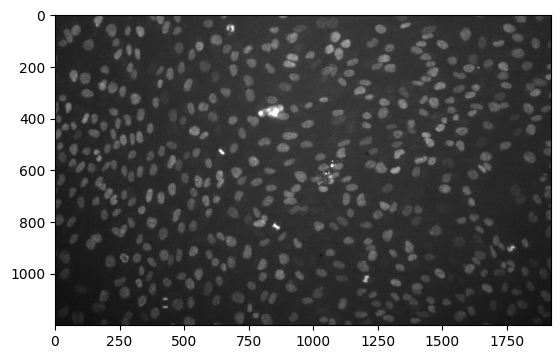

In [6]:
plt.imshow(example_image, cmap='gray')

In [2]:
for index, row in mod_df.iterrows():
    print(row)

PathName    AllLabels/labels/20220329_C2_P01t015.txt
SeriesID                                           1
ClassID                                            9
XCenter                                     0.090625
YCenter                                         0.95
Width                           0.022916666666666665
Height                          0.041666666666666664
Name: 0, dtype: object
PathName    AllLabels/labels/20220329_C2_P01t015.txt
SeriesID                                           1
ClassID                                            8
XCenter                          0.09114583333333333
YCenter                                         0.95
Width                           0.022916666666666665
Height                          0.041666666666666664
Name: 1, dtype: object
PathName    AllLabels/labels/20220329_C2_P01t015.txt
SeriesID                                           1
ClassID                                            7
XCenter                          0.09166666666666666


PathName    AllLabels/labels/20220727_C1_P02_S1_t019.txt
SeriesID                                               1
ClassID                                                7
XCenter                                        0.3734375
YCenter                               0.6741666666666667
Width                               0.027083333333333334
Height                               0.03833333333333333
Name: 1156, dtype: object
PathName    AllLabels/labels/20220727_C1_P02_S1_t019.txt
SeriesID                                               1
ClassID                                                6
XCenter                               0.3729166666666667
YCenter                               0.6733333333333333
Width                               0.027083333333333334
Height                               0.03833333333333333
Name: 1157, dtype: object
PathName    AllLabels/labels/20220727_C1_P02_S1_t019.txt
SeriesID                                               1
ClassID                             

In [1]:
from CellClicker.manageXML import cell_xml_to_dataframe
cell_xml_to_dataframe("cell_regions.xml")

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
2
3
1
2
1
2
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


,PathName,SeriesID,ClassID,XCenter,YCenter,Width,Height
0,AllLabels/labels/20220329_C2_P01t015.txt,1,0,0.090625,0.95,0.022916666666666665,0.041666666666666664
1,AllLabels/labels/20220329_C2_P01t015.txt,1,1,0.09114583333333333,0.95,0.022916666666666665,0.041666666666666664
2,AllLabels/labels/20220329_C2_P01t015.txt,1,2,0.09166666666666666,0.95,0.022916666666666665,0.041666666666666664
3,AllLabels/labels/20220329_C2_P01t015.txt,1,3,0.0921875,0.9558333333333333,0.022916666666666665,0.041666666666666664
4,AllLabels/labels/20220329_C2_P01t015.txt,1,4,0.0921875,0.9558333333333333,0.022916666666666665,0.041666666666666664
...,...,...,...,...,...,...,...
1373,AllLabels/labels/20220727_C1_P03_S2_t023.txt,1,4,0.8869791666666667,0.37166666666666665,0.023958333333333335,0.043333333333333335
1374,AllLabels/labels/20220727_C1_P03_S2_t023.txt,1,5,0.8885416666666667,0.36916666666666664,0.023958333333333335,0.043333333333333335
1375,AllLabels/labels/20220727_C1_P03_S2_t023.txt,1,6,0.8901041666666667,0.3675,0.023958333333333335,0.043333333333333335
1376,AllLabels/labels/20220727_C1_P03_S2_t023.txt,1,7,0.8880208333333334,0.36583333333333334,0.023958333333333335,0.043333333333333335


In [1]:
from CellClicker.image_selector import debug_xml_to_labels
user_df, cell_df = debug_xml_to_labels("select_xmls/sara.xml","cell_regions.xml")

AllLabels/labels/20220329_C2_P01t015.txt
AllLabels/labels/20220329_C2_P02t014.txt
AllLabels/labels/20220329_C2_P03t011.txt
AllLabels/labels/20220329_C2_P03t012.txt
AllLabels/labels/20220329_C2_P03t010.txt
AllLabels/labels/20220329_C2_P03t008.txt
AllLabels/labels/20220329_C2_P04t011.txt
AllLabels/labels/20220329_C2_P04t014.txt
AllLabels/labels/20220329_C2_P05t014.txt
AllLabels/labels/20220329_C2_P05t011.txt
AllLabels/labels/20220329_C2_P04t009.txt
AllLabels/labels/20220329_C2_P04t013.txt
AllLabels/labels/20220329_C2_P05t007.txt
AllLabels/labels/20220329_C2_P06t010.txt
AllLabels/labels/20220329_C2_P06t009.txt
AllLabels/labels/20220329_C2_P06t011.txt
AllLabels/labels/20220329_C2_P06t012.txt
AllLabels/labels/20220329_C2_P06t012.txt
AllLabels/labels/20220329_C2_P06t013.txt
AllLabels/labels/20220329_C2_P06t016.txt
AllLabels/labels/20220329_C2_P06t016.txt
AllLabels/labels/20220329_C2_P07t007.txt
AllLabels/labels/20220329_C2_P07t008.txt
AllLabels/labels/20220329_C2_P07t013.txt
AllLabels/labels

In [2]:
print(user_df)

                                         PathName  SeriesID  SelectedIndex
0        AllLabels/labels/20220329_C2_P01t015.txt         1              7
1        AllLabels/labels/20220329_C2_P02t014.txt         1              7
2        AllLabels/labels/20220329_C2_P03t011.txt         1              6
3        AllLabels/labels/20220329_C2_P03t012.txt         1              6
4        AllLabels/labels/20220329_C2_P03t010.txt         1              6
..                                            ...       ...            ...
150  AllLabels/labels/20220727_C1_P02_S1_t019.txt         1              6
151  AllLabels/labels/20220727_C1_P02_S2_t010.txt         1              6
152  AllLabels/labels/20220727_C1_P02_S2_t019.txt         1              7
153  AllLabels/labels/20220727_C1_P03_S1_t023.txt         1             -1
154  AllLabels/labels/20220727_C1_P03_S2_t023.txt         1              7

[155 rows x 3 columns]


In [3]:
for index, row in cell_df.iterrows():
    print(row)

PathName    AllLabels/labels/20220329_C2_P01t015.txt
SeriesID                                           1
ClassID                                            0
XCenter                                     0.090625
YCenter                                         0.95
Width                           0.022916666666666665
Height                          0.041666666666666664
Name: 0, dtype: object
PathName    AllLabels/labels/20220329_C2_P01t015.txt
SeriesID                                           1
ClassID                                            1
XCenter                          0.09114583333333333
YCenter                                         0.95
Width                           0.022916666666666665
Height                          0.041666666666666664
Name: 1, dtype: object
PathName    AllLabels/labels/20220329_C2_P01t015.txt
SeriesID                                           1
ClassID                                            2
XCenter                          0.09166666666666666


PathName    AllLabels/labels/20220329_C3_P15t052.txt
SeriesID                                           1
ClassID                                            8
XCenter                                    0.3109375
YCenter                                       0.4425
Width                           0.026041666666666668
Height                           0.04833333333333333
Name: 1296, dtype: object
PathName    AllLabels/labels/20220329_C3_P15t056.txt
SeriesID                                           1
ClassID                                            0
XCenter                                    0.0421875
YCenter                           0.9804166666666667
Width                           0.023958333333333335
Height                           0.04083333333333333
Name: 1297, dtype: object
PathName    AllLabels/labels/20220329_C3_P15t056.txt
SeriesID                                           1
ClassID                                            1
XCenter                         0.0432291666666

In [5]:
print(cell_df)

Empty DataFrame
Columns: []
Index: []


In [1]:
from CellClicker.user_xml import read_xml_to_dataframe
user_df = read_xml_to_dataframe("select_xmls/scott.xml")
user_df.head()

finder-camera4_3\labels\20220329_4_3_P1 - 1t027.txt
finder-camera4_3\labels\20220329_4_3_P1 - 1t035.txt
finder-camera4_3\labels\20220329_4_3_P1 - 1t043.txt
finder-camera4_3\labels\20220329_4_3_P1 - 1t050.txt
finder-camera4_3\labels\20220329_4_3_P1 - 1t054.txt


,PathName,SeriesID,SelectedIndex
0,finder-camera4_3\labels\20220329_4_3_P1 - 1t02...,1,6
1,finder-camera4_3\labels\20220329_4_3_P1 - 1t03...,1,7
2,finder-camera4_3\labels\20220329_4_3_P1 - 1t04...,1,6
3,finder-camera4_3\labels\20220329_4_3_P1 - 1t05...,1,6
4,finder-camera4_3\labels\20220329_4_3_P1 - 1t05...,1,5


In [2]:
from CellClicker.manageXML import cell_xml_to_dataframe
xml_file_path = "cell_regions.xml"
cell_df = cell_xml_to_dataframe(xml_file_path)
print(cell_df)

                                             PathName SeriesID ClassID  \
0   finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       0   
1   finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       1   
2   finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       2   
3   finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       3   
4   finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       4   
5   finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       5   
6   finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       6   
7   finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       7   
8   finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       8   
9   finder-camera4_3/labels/20220329_4_3_P1 - 1t03...        1       0   
10  finder-camera4_3/labels/20220329_4_3_P1 - 1t03...        1       1   
11  finder-camera4_3/labels/20220329_4_3_P1 - 1t03...        1       2   
12  finder-camera4_3/labels/20220329_4

In [6]:
import pandas as pd
def modify_class_ids(df, selected_indices_df, target_class_id):
    # Normalize the path names in both DataFrames
    df['PathName'] = df['PathName'].apply(lambda x: x.replace('\\', '/'))
    selected_indices_df['PathName'] = selected_indices_df['PathName'].apply(lambda x: x.replace('\\', '/'))

    # Ensure SeriesID is consistent in type (e.g., both as strings)
    df['SeriesID'] = df['SeriesID'].astype(str)
    selected_indices_df['SeriesID'] = selected_indices_df['SeriesID'].astype(str)

    modified_data = []



    for _, row in selected_indices_df.iterrows():
        path_name = row['PathName']
        series_id = row['SeriesID']
        selected_index = row['SelectedIndex']

        print(f"Processing PathName: {path_name}, SeriesID: {series_id}, SelectedIndex: {selected_index}")

        group = df[(df['PathName'] == path_name) & (df['SeriesID'] == str(series_id))]

        if not group.empty:
            print("Filtered Group:\n", group)  # Debugging: print the filtered group

            # Calculate new ClassIDs
#             new_class_ids = list(range(len(group) - 1, selected_index - 1, -1)) + \
#                             [target_class_id] + \
#                             list(range(1, len(group) - selected_index))
            
            
#             selected = 5
#             0 1 2 3 4 5 6 7 8 becomes
#             7 6 5 4 3 2 1 0
            
#             selected = 6
#             0 1 2 3 4 5 6 7 8 becomes
#             8 7 6 5 4 3 2 1 0
            
            print(selected_index, target_class_id)
            
            new_class_ids = list(reversed(list(range(selected_index + target_class_id+1))))
            print(new_class_ids)
            print(len(group['ClassID']))
#             # Truncate the group if new_class_ids is shorter than the length of the group
            if len(new_class_ids) < len(group):
                group = group.iloc[:len(new_class_ids)]
            elif len(new_class_ids) > len(group):
                new_class_ids = new_class_ids[:len(group)]

            # Update the group with new class IDs
            group = group.copy()
            group['ClassID'] = new_class_ids


            modified_data.append(group)

        # Concatenate all modified groups into a new DataFrame
        modified_df = pd.concat(modified_data, ignore_index=True)

    return modified_df
#         else:
#             print(f"No data found for PathName: {path_name}, SeriesID: {series_id}")

#     # Concatenate all modified groups into a new DataFrame
#     modified_df = pd.concat(modified_data, ignore_index=True)

#     print("Modified DataFrame:\n", modified_df.head())  # Debugging: print first few rows of the modified DataFrame

#     return modified_df

In [7]:
selected_index = 5
list(reversed(list(range(selected_index+3))))[:5]

[7, 6, 5, 4, 3]

In [8]:
target_class_id = 2
modified_df = modify_class_ids(cell_df, user_df, target_class_id)

print(modified_df)

Processing PathName: finder-camera4_3/labels/20220329_4_3_P1 - 1t027.txt, SeriesID: 1, SelectedIndex: 6
Filtered Group:
                                             PathName SeriesID ClassID  \
0  finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       0   
1  finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       1   
2  finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       2   
3  finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       3   
4  finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       4   
5  finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       5   
6  finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       6   
7  finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       7   
8  finder-camera4_3/labels/20220329_4_3_P1 - 1t02...        1       8   

               XCenter             YCenter                 Width  \
0  0.27708333333333335  0.8566666666666667  0.029166666666666667   
1           

In [9]:
"finder-camera4_3/labels/20220329_4_3_P1 - 1t027.txt" in user_df

False

In [10]:
for pname, pname2 in zip(cell_df['PathName'], user_df['PathName']):
    print("cell")
    print(pname)
    print("user")
    print(pname2)
    print(pname == pname2)

cell
finder-camera4_3/labels/20220329_4_3_P1 - 1t027.txt
user
finder-camera4_3/labels/20220329_4_3_P1 - 1t027.txt
True
cell
finder-camera4_3/labels/20220329_4_3_P1 - 1t027.txt
user
finder-camera4_3/labels/20220329_4_3_P1 - 1t035.txt
False
cell
finder-camera4_3/labels/20220329_4_3_P1 - 1t027.txt
user
finder-camera4_3/labels/20220329_4_3_P1 - 1t043.txt
False
cell
finder-camera4_3/labels/20220329_4_3_P1 - 1t027.txt
user
finder-camera4_3/labels/20220329_4_3_P1 - 1t050.txt
False
cell
finder-camera4_3/labels/20220329_4_3_P1 - 1t027.txt
user
finder-camera4_3/labels/20220329_4_3_P1 - 1t054.txt
False


In [11]:
path_name = "finder-camera4_3/labels/20220329_4_3_P1 - 1t027.txt"
series_id = "1"
df =cell_df
group = df[(df['PathName'] == path_name) & (df['SeriesID'] == series_id)]
group

,PathName,SeriesID,ClassID,XCenter,YCenter,Width,Height
0,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,0,0.27708333333333335,0.8566666666666667,0.029166666666666667,0.04666666666666667
1,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,1,0.278125,0.85,0.029166666666666667,0.04666666666666667
2,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,2,0.2796875,0.8483333333333334,0.029166666666666667,0.04666666666666667
3,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,3,0.278125,0.8508333333333333,0.029166666666666667,0.04666666666666667
4,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,4,0.2791666666666667,0.8533333333333334,0.029166666666666667,0.04666666666666667
5,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,5,0.2786458333333333,0.8558333333333333,0.029166666666666667,0.04666666666666667
6,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,6,0.278125,0.8583333333333333,0.029166666666666667,0.04666666666666667
7,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,7,0.2796875,0.8575,0.029166666666666667,0.04666666666666667
8,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,8,0.2786458333333333,0.8566666666666667,0.029166666666666667,0.04666666666666667


In [66]:
modified_df

,PathName,SeriesID,ClassID,XCenter,YCenter,Width,Height
0,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,8,0.27708333333333335,0.8566666666666667,0.029166666666666667,0.04666666666666667
1,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,7,0.278125,0.85,0.029166666666666667,0.04666666666666667
2,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,6,0.2796875,0.8483333333333334,0.029166666666666667,0.04666666666666667
3,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,5,0.278125,0.8508333333333333,0.029166666666666667,0.04666666666666667
4,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,4,0.2791666666666667,0.8533333333333334,0.029166666666666667,0.04666666666666667
5,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,3,0.2786458333333333,0.8558333333333333,0.029166666666666667,0.04666666666666667
6,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,2,0.278125,0.8583333333333333,0.029166666666666667,0.04666666666666667
7,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,1,0.2796875,0.8575,0.029166666666666667,0.04666666666666667
8,finder-camera4_3/labels/20220329_4_3_P1 - 1t02...,1,0,0.2786458333333333,0.8566666666666667,0.029166666666666667,0.04666666666666667
9,finder-camera4_3/labels/20220329_4_3_P1 - 1t03...,1,9,0.24375,0.9408333333333333,0.025,0.05


In [68]:
from CellClicker.clicker_utils import append_yolov5_label, get_relative_image_name
for index, row in df.iterrows():
    label_path = row['PathName'].replace("labels", "inspectlabels")
    x_center= float(row['XCenter'])
    y_center= float(row['YCenter'])
    width= float(row['Width'])
    height= float(row['Height'])
    img_width = img_height = 1
    class_id= int(row['ClassID'])

    append_yolov5_label(label_path, x_center, y_center, width, height, img_width, img_height, class_id)

In [15]:
from CellClicker.clicker_utils import append_yolov5_label, get_relative_label_name
def append_modified_labels(df):
    # Group by 'ImageName' and 'SeriesID'
    grouped = df.groupby(['PathName', 'SeriesID'])

    for (label_path, series_id), group in grouped:
#         print(f"Processing Group: ImageName={image_name}, SeriesID={series_id}")
        label_path = label_path.replace("labels", "inspectlabels")
        print(label_path)
        for index, row in group.iterrows():
            
            x_center= float(row['XCenter'])
            y_center= float(row['YCenter'])
            width= float(row['Width'])
            height= float(row['Height'])
            img_width = img_height = 1
            class_id= int(row['ClassID'])
            print(label_path)
            append_yolov5_label(label_path, x_center, y_center, width, height, img_width, img_height, class_id)
            label_path = get_relative_label_name(label_path, 1)
            
append_modified_labels(modified_df)

finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t027.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t027.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t026.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t025.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t024.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t023.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t022.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t021.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t020.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t019.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t035.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t035.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t034.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t033.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t032.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t031.txt
finder-camera4_3/inspectlabels/20220329_4_3_P1 - 1t030.t